In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

In [95]:
# Load data
data = pd.read_csv('beer_production.csv', parse_dates=['Month'], index_col='Month')
data.columns = ['Production']

In [96]:
# Create time series features
def create_time_series_features(data):
    # Lagged values
    for i in range(1, 13):
        data[f'lag_{i}'] = data['Production'].shift(i)

    # Rolling statistics
    data['rolling_mean'] = data['Production'].rolling(window=12).mean()
    data['rolling_std'] = data['Production'].rolling(window=12).std()

    # Date-based features
    data['month'] = data.index.month
    data['quarter'] = data.index.quarter

    # Trend
    data['trend'] = np.arange(len(data))

    # Drop missing values created by lags and rolling stats
    data = data.dropna()
    return data

In [97]:
# Add features to the dataset
data = create_time_series_features(data)

In [98]:
# Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

In [99]:
# Prepare features and target
X_train = train.drop(columns=['Production'])
y_train = train['Production']
X_test = test.drop(columns=['Production'])
y_test = test['Production']

In [100]:
# Standardize features (SVM is sensitive to feature scales)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [101]:
# Initialize and fit SVR model
model = SVR(
    kernel='rbf',
    C=1.0,
    epsilon=0.1
)

In [102]:
model.fit(X_train_scaled, y_train)

SVR()

In [103]:
# Make predictions
predictions = model.predict(X_test_scaled)

In [104]:
# Evaluate the model
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

In [105]:
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared: {r2:.4f}")

Mean Squared Error (MSE): 334.6092
Mean Absolute Error (MAE): 13.8068
R-squared: 0.3187


- The model has **moderate predictive accuracy**

In [106]:
# Cross-validation (optional, for more robust evaluation)
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-validated MSE: {-cv_scores.mean():.4f}")

Cross-validated MSE: 522.1673


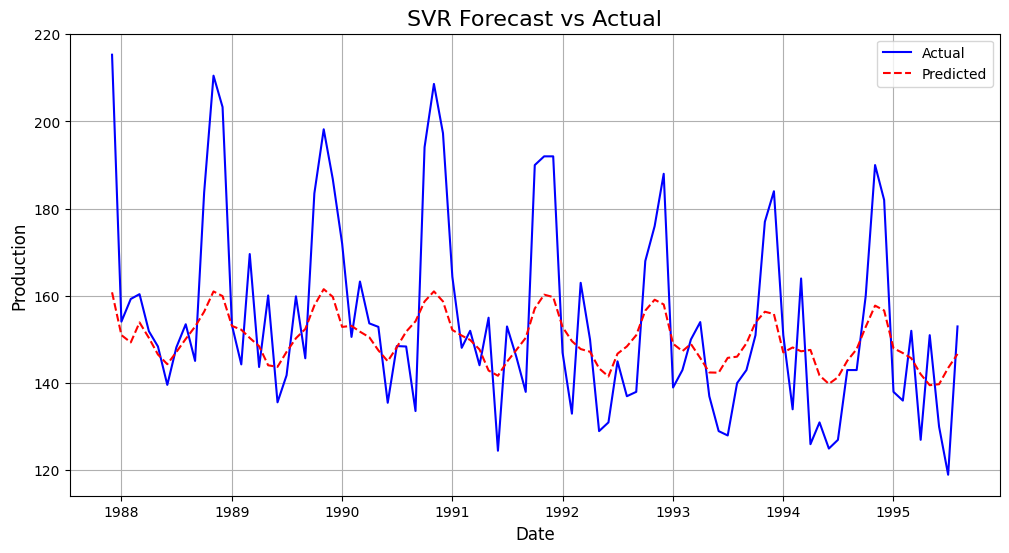

In [107]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Actual', color='blue')
plt.plot(test.index, predictions, label='Predicted', color='red', linestyle='dashed')
plt.title('SVR Forecast vs Actual', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Production', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

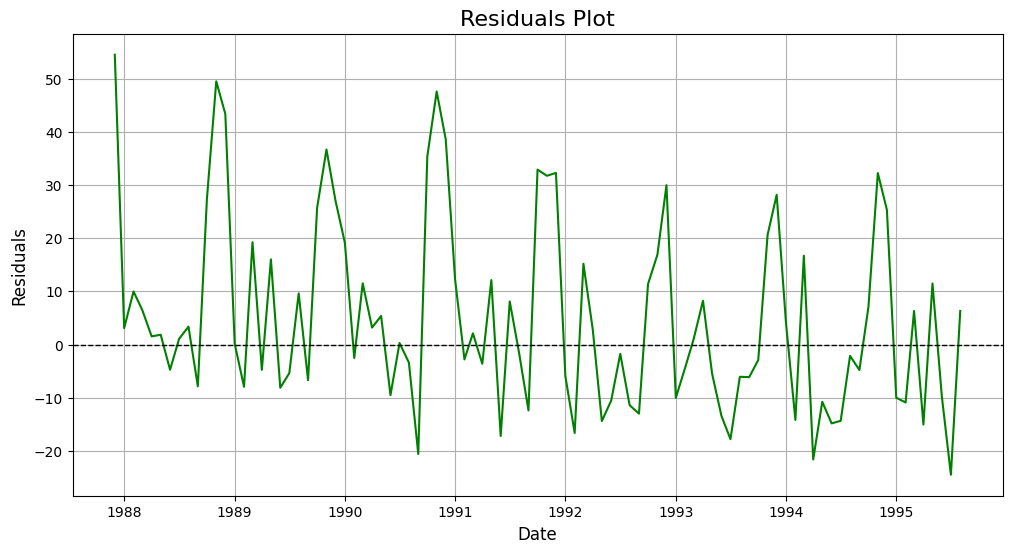

In [108]:
# Plot residuals (difference between actual and predicted values)
residuals = y_test - predictions
plt.figure(figsize=(12, 6))
plt.plot(test.index, residuals, label='Residuals', color='green')
plt.title('Residuals Plot', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.grid(True)
plt.axhline(0, color='black', linestyle='dashed', linewidth=1)
plt.show()

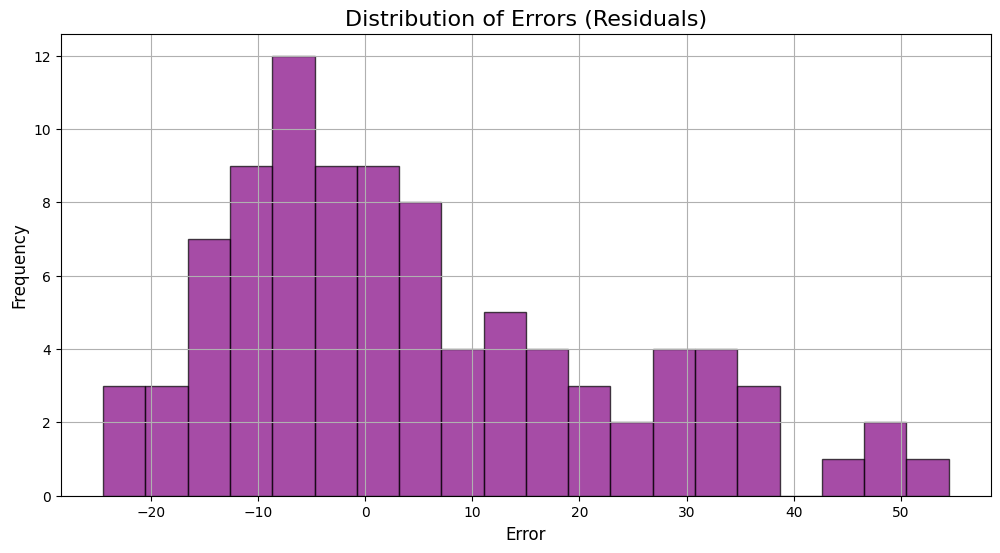

In [109]:
# Distribution of errors
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=20, color='purple', edgecolor='black', alpha=0.7)
plt.title('Distribution of Errors (Residuals)', fontsize=16)
plt.xlabel('Error', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.show()

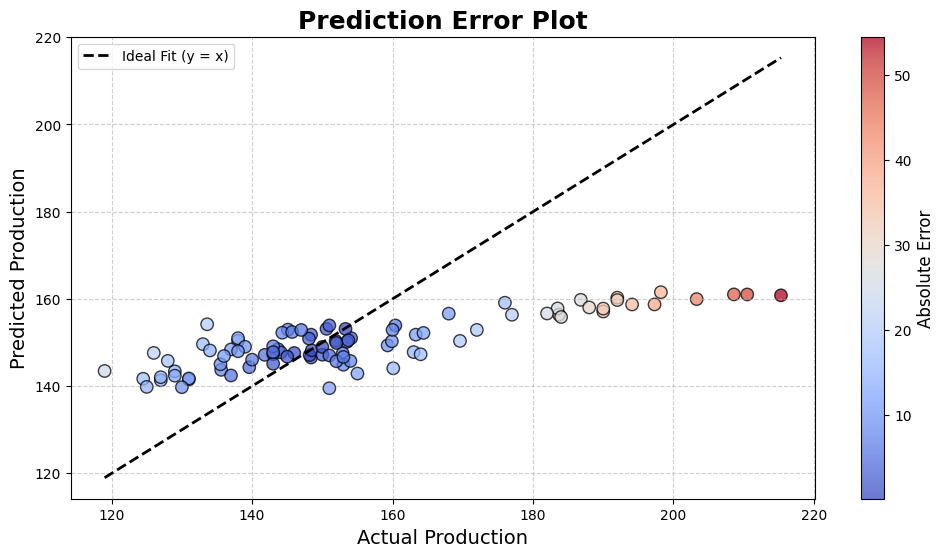

In [111]:
plt.figure(figsize=(12, 6))

errors = np.abs(y_test - predictions)
plt.scatter(y_test, predictions, c=errors, cmap='coolwarm', edgecolor='black', s=80, alpha=0.75)

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='dashed', color='black', linewidth=2, label='Ideal Fit (y = x)')

plt.title('Prediction Error Plot', fontsize=18, fontweight='bold')
plt.xlabel('Actual Production', fontsize=14)
plt.ylabel('Predicted Production', fontsize=14)

cbar = plt.colorbar()
cbar.set_label('Absolute Error', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.6)

plt.legend()
plt.show()
